<h2>Testing Pytorch in LSTM</h2>

<h3>Loading libraries</h3>

In [28]:
#@libraries using in work

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

#@library for optimization
import wandb as wb # Optimization

#@libraries using in Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import torch.utils.data as Dataset
import torch.utils.data as DataLoader

#@Libraries for import Stocks
from yahoo_fin.stock_info import get_data

#@Libraries for transformartion, scale anda erros
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#@libraries for adjust time
import datetime as dt
print("Libraries loaded")

Libraries loaded


<h3>Verification of CPU</h3>

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

<h3>Extraction of Cryptocurrency</h3>

In [8]:
START_DATE = dt.datetime(2018,1,1)

END_DATE = dt.datetime(2023,8,24)

dataset = get_data('BTC-USD', 
                   start_date=START_DATE, 
                   end_date=END_DATE, 
                   index_as_date = True, 
                   interval="1d")

data = dataset.dropna()

data = data.iloc[:,3:4].dropna()

data.head(3)

,close
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000


<h3>Data visualization</h3>

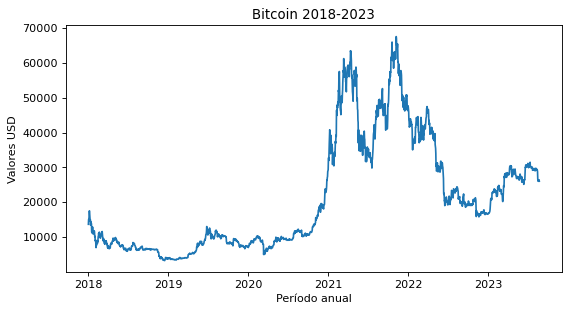

In [9]:
fig = figure(figsize=(8,4), dpi=80)
plt.plot(data)
plt.xlabel('Período anual')
plt.ylabel('Valores USD')
plt.title('Bitcoin 2018-2023')
plt.show()

<h3>Data preparation</h3>

In [11]:
#@ Tranformation of data in MinMaxScaler
data=data.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))

data['close'] = scaler.fit_transform(data['close'].values.reshape(-1,1))

data.head(3)

,close
2018-01-01,-0.676032
2018-01-02,-0.634841
2018-01-03,-0.628036


In [13]:
data.describe()

,close
count,2062.000000
mean,-0.446898
std,0.501879
min,-1.000000
25%,-0.846626
50%,-0.643159
75%,-0.155626
max,1.000000


<h3>Building function for transformation, create length, groups of test and train</h3>

In [15]:
def load_data(crypto, look_back):
    data_raw = crypto.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

#@ Definition of parameters:

look_back = 60 # choose sequence length

x_train, y_train, x_test, y_test = load_data(data, look_back)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1602, 59, 1)
y_train.shape =  (1602, 1)
x_test.shape =  (400, 59, 1)
y_test.shape =  (400, 1)


<h3>Creating Tensor Torch</h3>

In [16]:
#@make training and test sets in torch

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [17]:
y_train.size(),x_train.size()

(torch.Size([1602, 1]), torch.Size([1602, 59, 1]))

<h3>Building Model</h3>

In [18]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [19]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

In [20]:
model

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [21]:

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


<h3>Phase of training of model</h3>

In [22]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()
    
    print("Completed Training")

Epoch  10 MSE:  0.08581100404262543
Epoch  20 MSE:  0.011089765466749668
Epoch  30 MSE:  0.009349772706627846
Epoch  40 MSE:  0.0048924102447927
Epoch  50 MSE:  0.0033362971153110266
Epoch  60 MSE:  0.0027116176206618547
Epoch  70 MSE:  0.0023279970046132803
Epoch  80 MSE:  0.002128248568624258
Epoch  90 MSE:  0.002027499722316861


<h3>Data Visualization</h3>

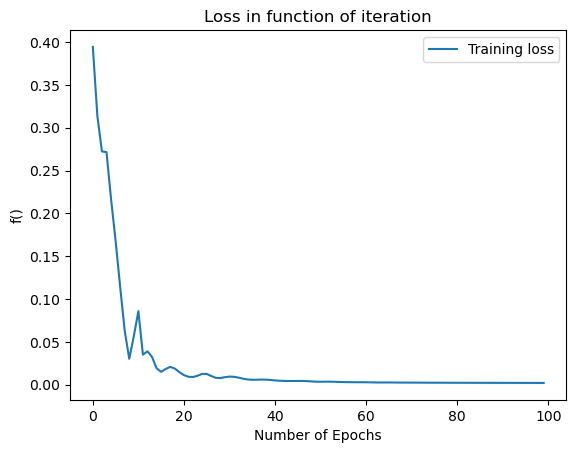

In [24]:
plt.plot(hist, label="Training loss")
plt.xlabel("Number of Epochs")
plt.ylabel("f()")
plt.title('Loss in function of iteration')
plt.legend()
plt.show()

In [25]:
np.shape(y_train_pred)

torch.Size([1602, 1])

<h3>Phase of predictions</h3>

In [26]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())

y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

<h3>Erro Calculate (RMSE)</h3>

In [29]:
#@calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1423.35 RMSE
Test Score: 1085.36 RMSE


In [39]:
from sklearn.metrics import mean_absolute_error

MAE_train_score = mean_absolute_error(y_train[:,0], y_train_pred[:,0])
print("Train Score:  %.2f MAE" %(MAE_train_score))

MAE_test_score = mean_absolute_error(y_test[:,0], y_test_pred[:,0])
print("Train Score:  %.2f MAE" %(MAE_test_score))

Train Score:  871.98 MAE
Train Score:  868.86 MAE


<h3>Data Visualization for Prediction</h3>

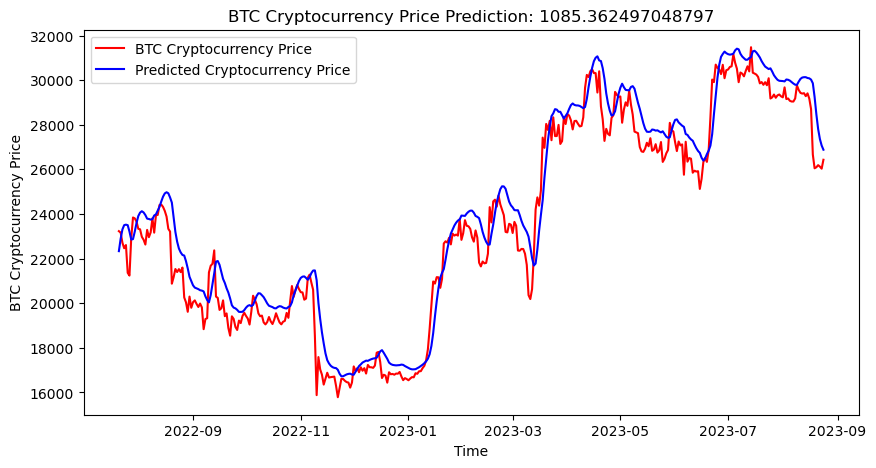

In [34]:
# Visualising the results
figure, axes = plt.subplots(figsize=(10, 5))
axes.xaxis_date()

axes.plot(data[len(data)-len(y_test):].index, y_test, color = 'red', label = 'BTC Cryptocurrency Price')
axes.plot(data[len(data)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Cryptocurrency Price')
#axes.xticks(np.arange(0,394,50))
plt.title(f"BTC Cryptocurrency Price Prediction: {testScore}")
plt.xlabel('Time')
plt.ylabel('BTC Cryptocurrency Price')
plt.legend()
#plt.savefig('ibm_pred.png')
plt.show()